In [24]:
# Set up for notebook

import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('bfry100_it4_app').getOrCreate()

In [2]:
# Read in data using pySpark method

df = spark.read.option("header",True).csv('Data/HeartData2020.csv')
df.printSchema()

root
 |-- Sex: string (nullable = true)
 |-- General_health: string (nullable = true)
 |-- Physical_health_30bad: string (nullable = true)
 |-- Mental_health_30bad: string (nullable = true)
 |-- Medical_cost: string (nullable = true)
 |-- Sleep_hours: string (nullable = true)
 |-- Stroke: string (nullable = true)
 |-- Asthma: string (nullable = true)
 |-- Skin_cancer: string (nullable = true)
 |-- Other_cancer: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Diff_con: string (nullable = true)
 |-- Diff_walk: string (nullable = true)
 |-- Smoked100: string (nullable = true)
 |-- Good_health: string (nullable = true)
 |-- Physical_act: string (nullable = true)
 |-- Heart_disease: string (nullable = true)
 |-- Age_group: string (nullable = true)
 |-- BMI: string (nullable = true)
 |-- Income_group: string (nullable = true)
 |-- Smoking_status: string (nullable = true)
 |-- Heavy_drink: string (nullable = true)



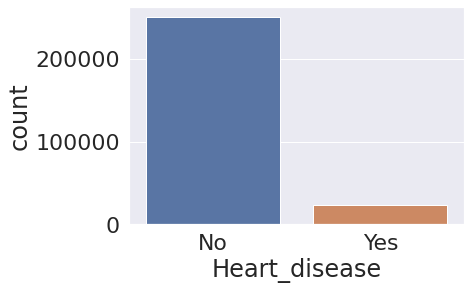

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


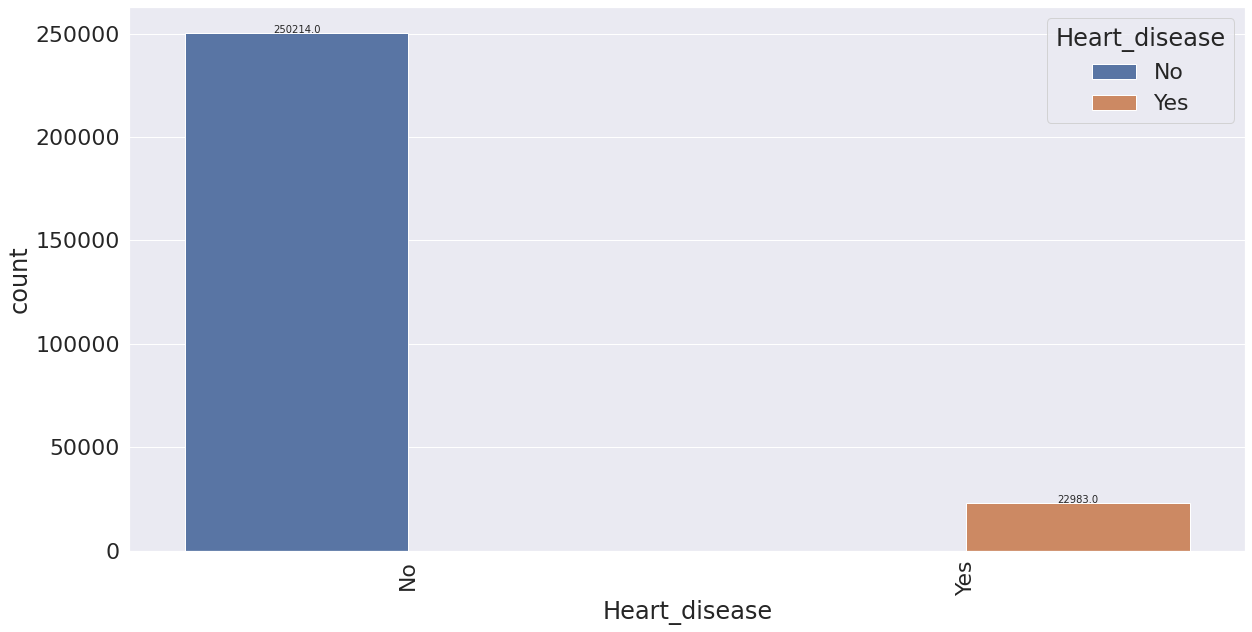

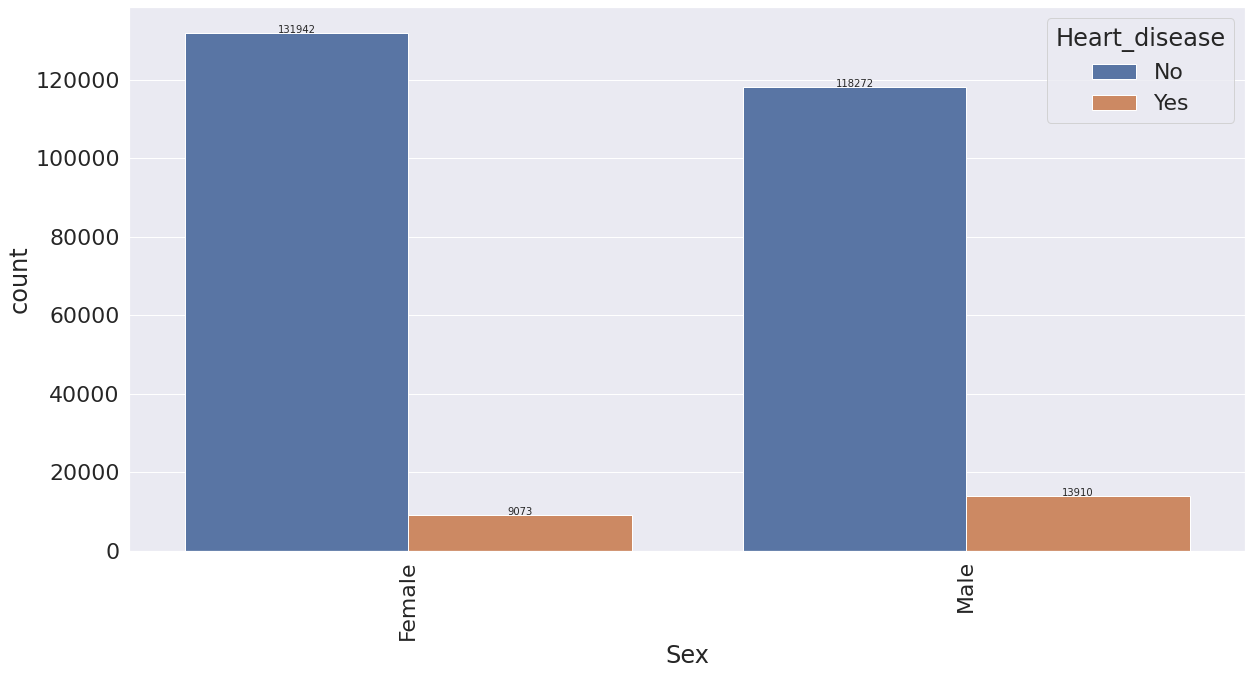

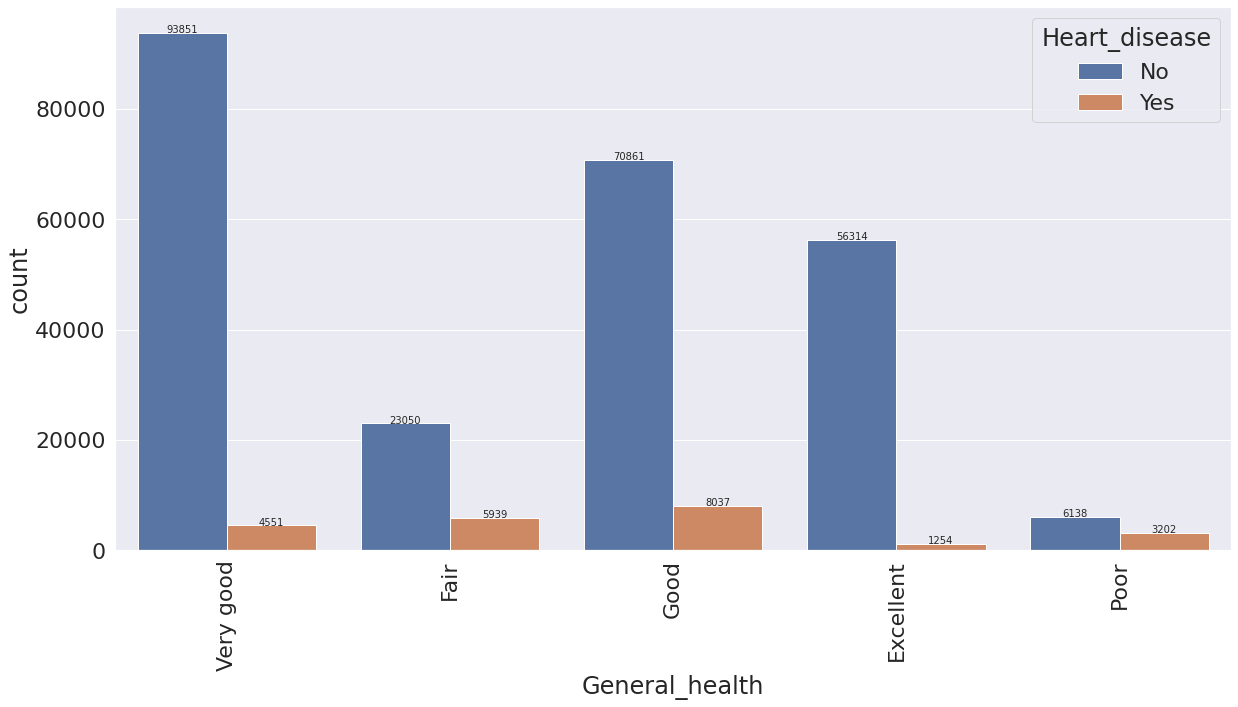

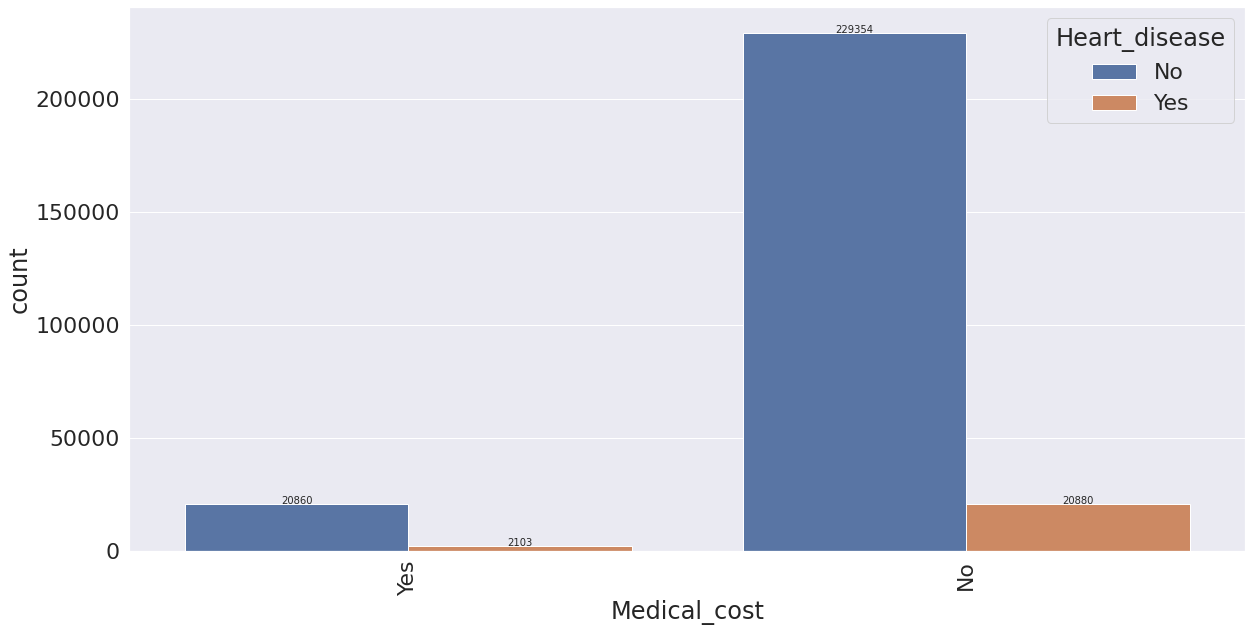

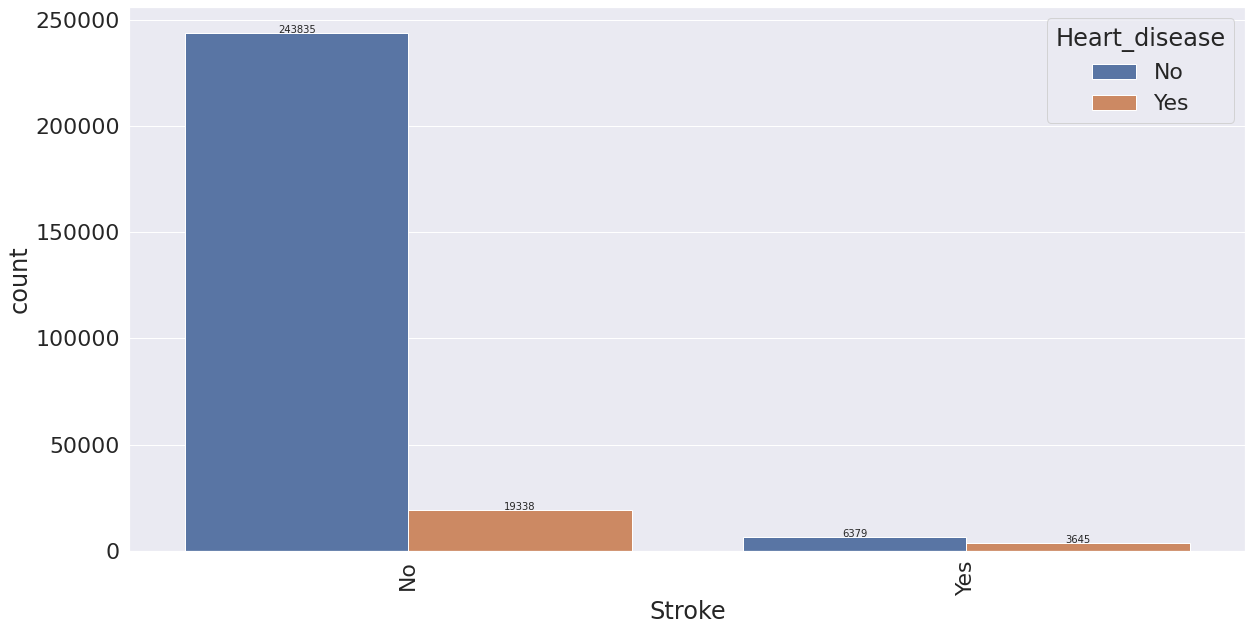

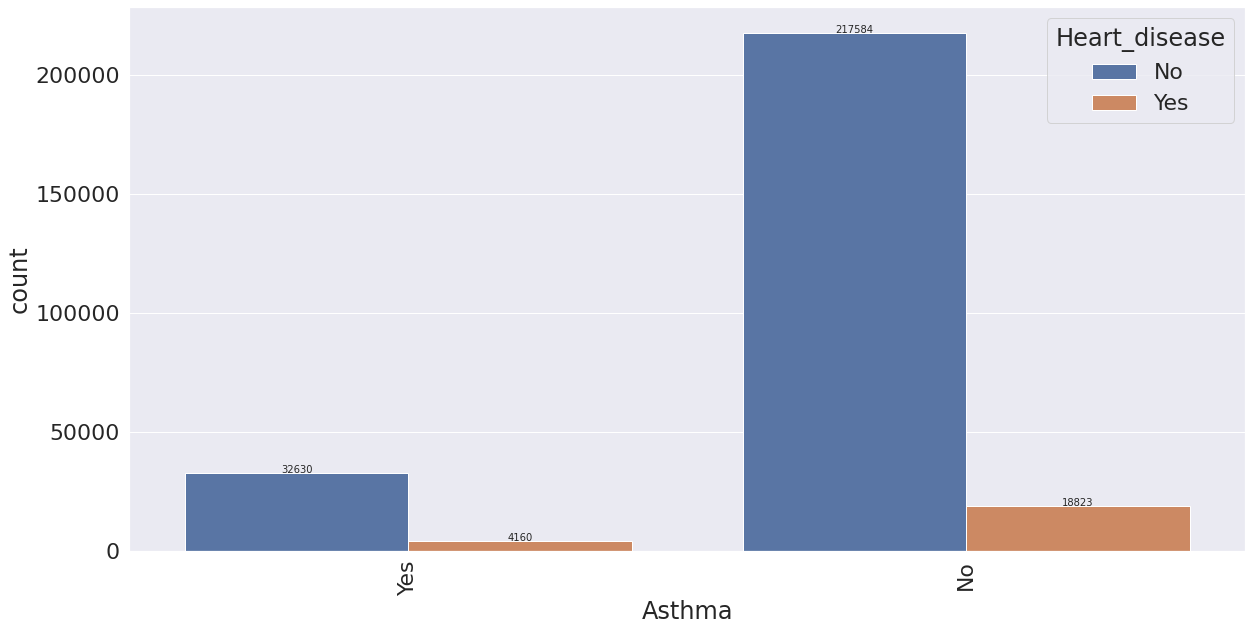

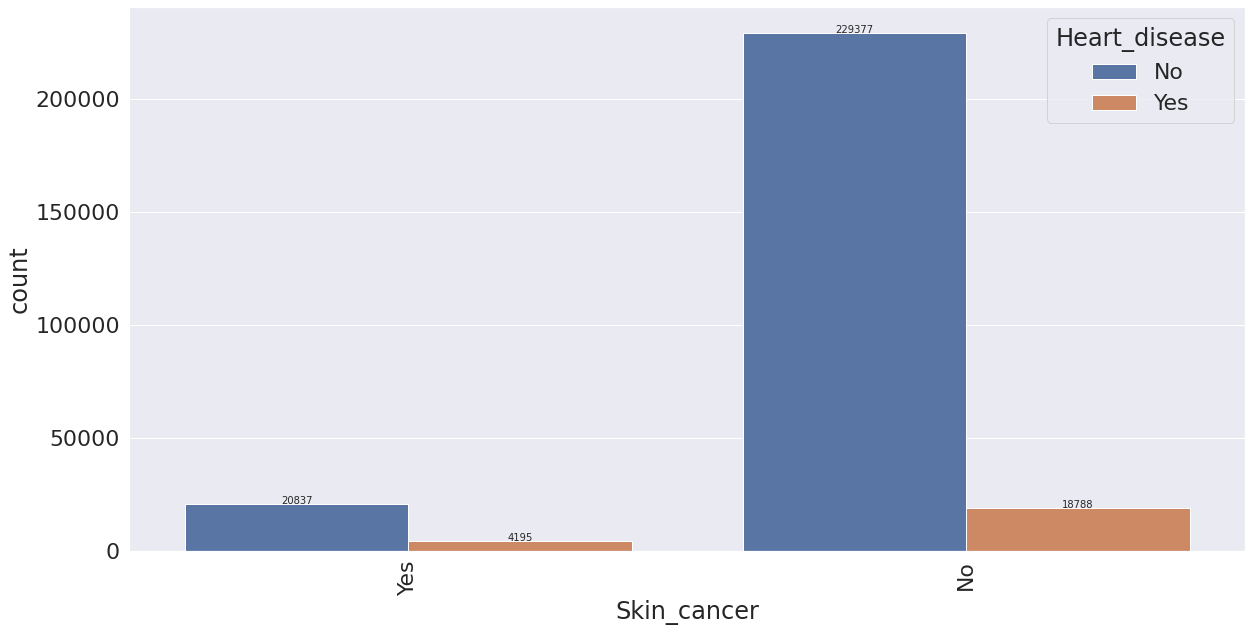

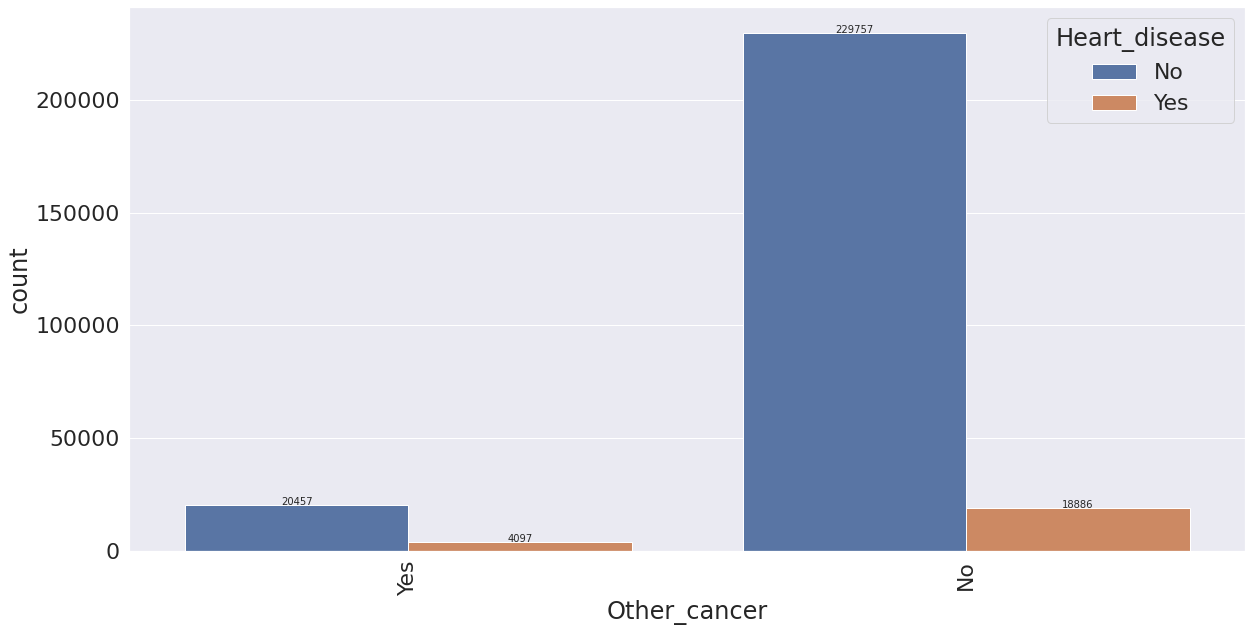

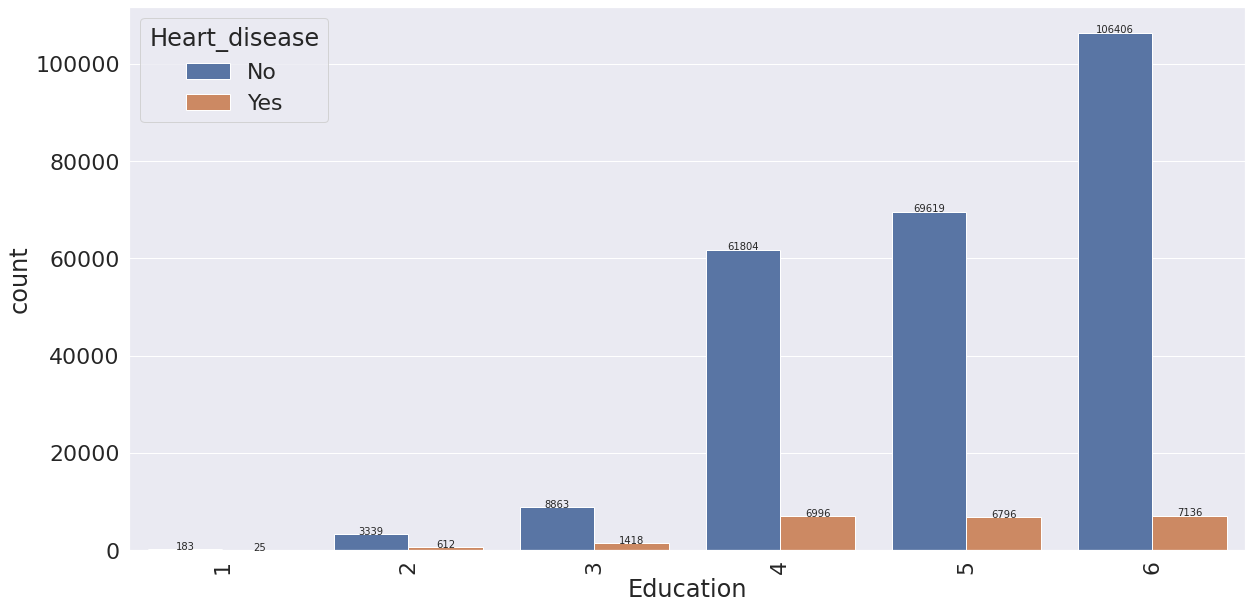

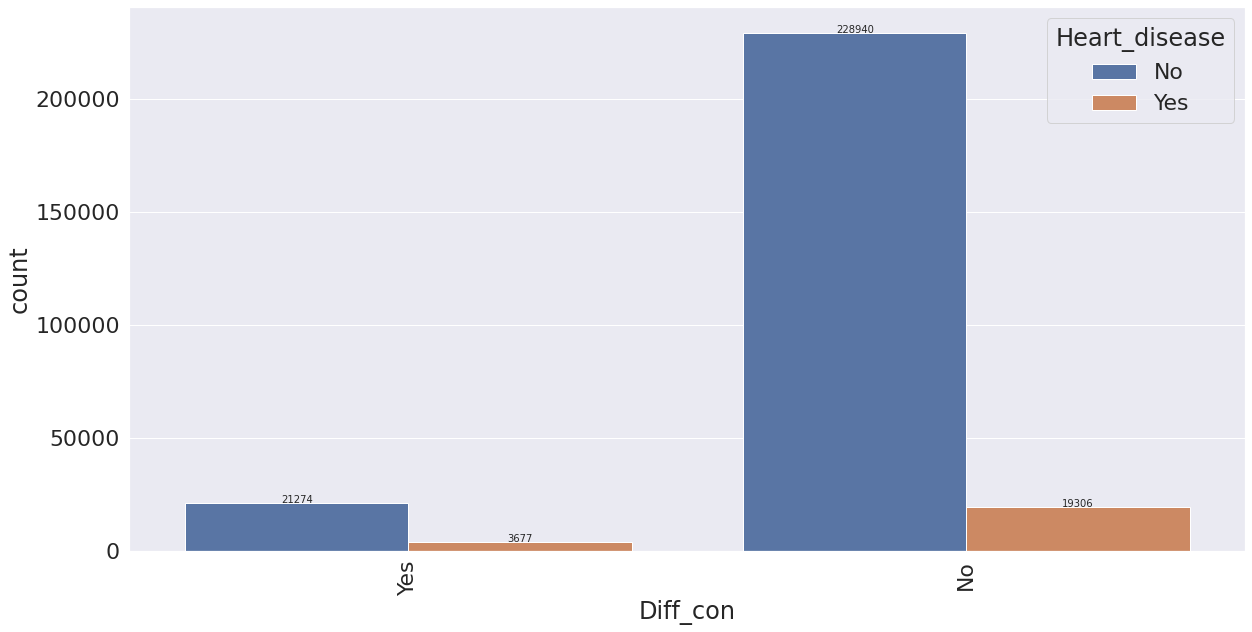

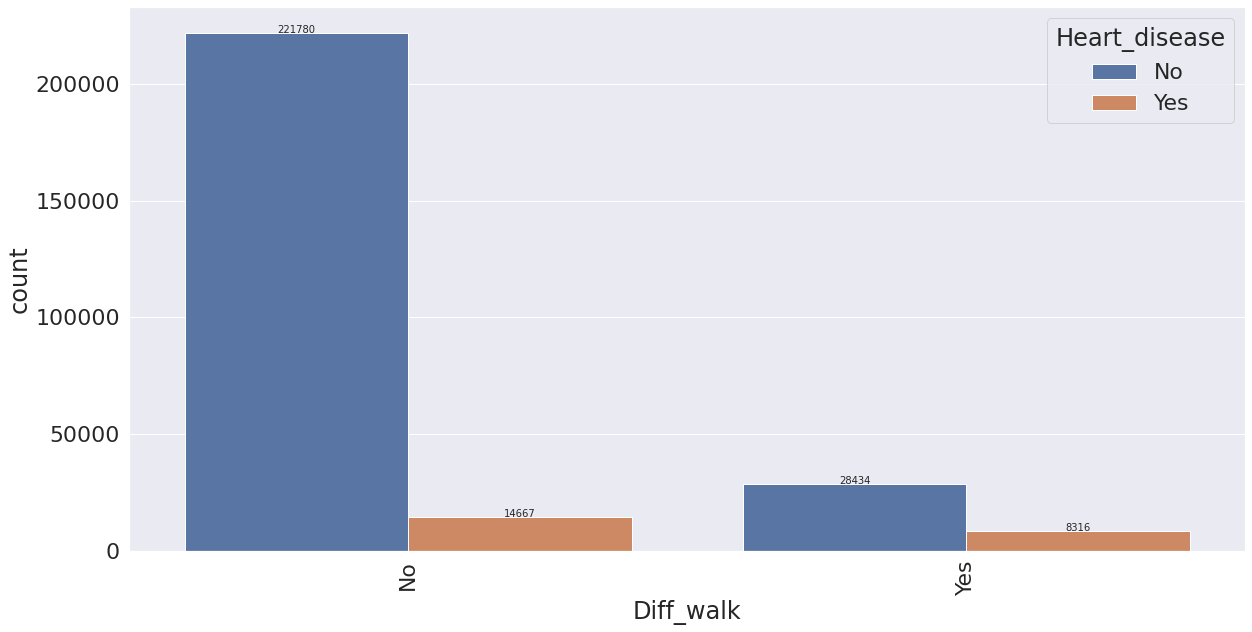

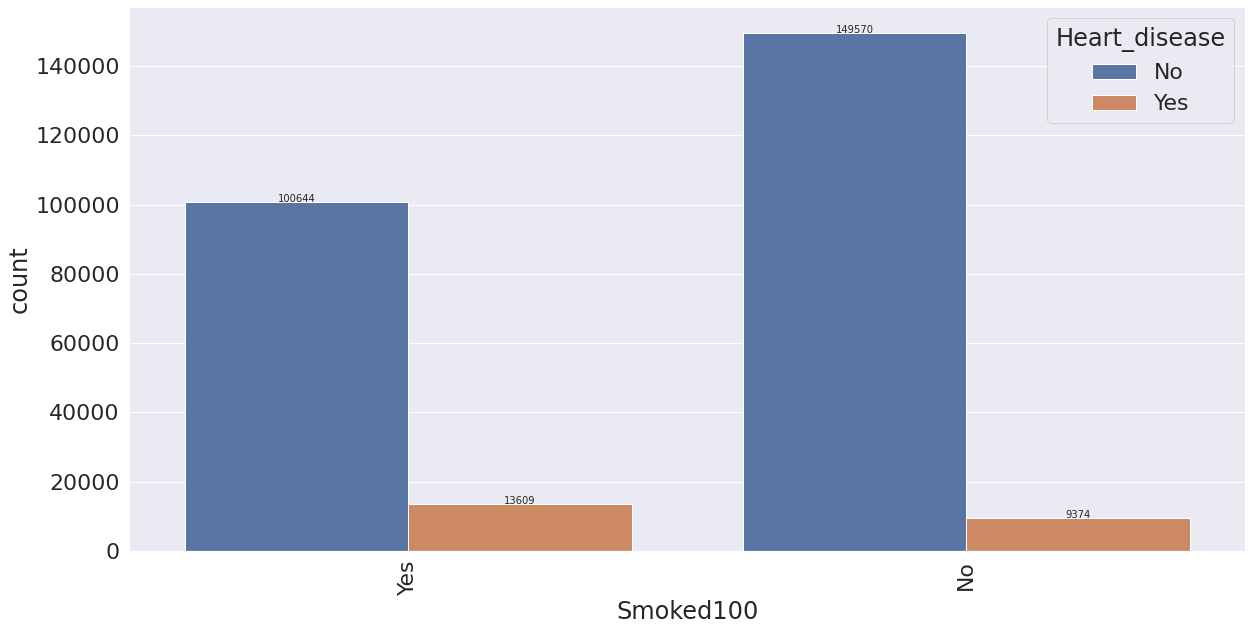

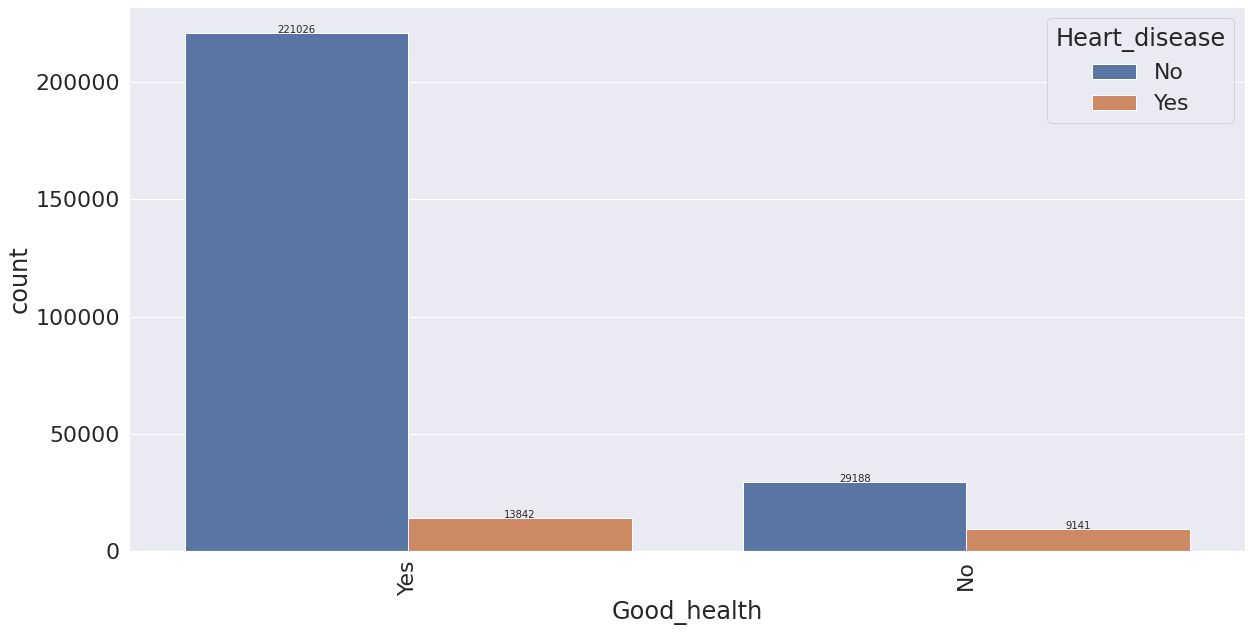

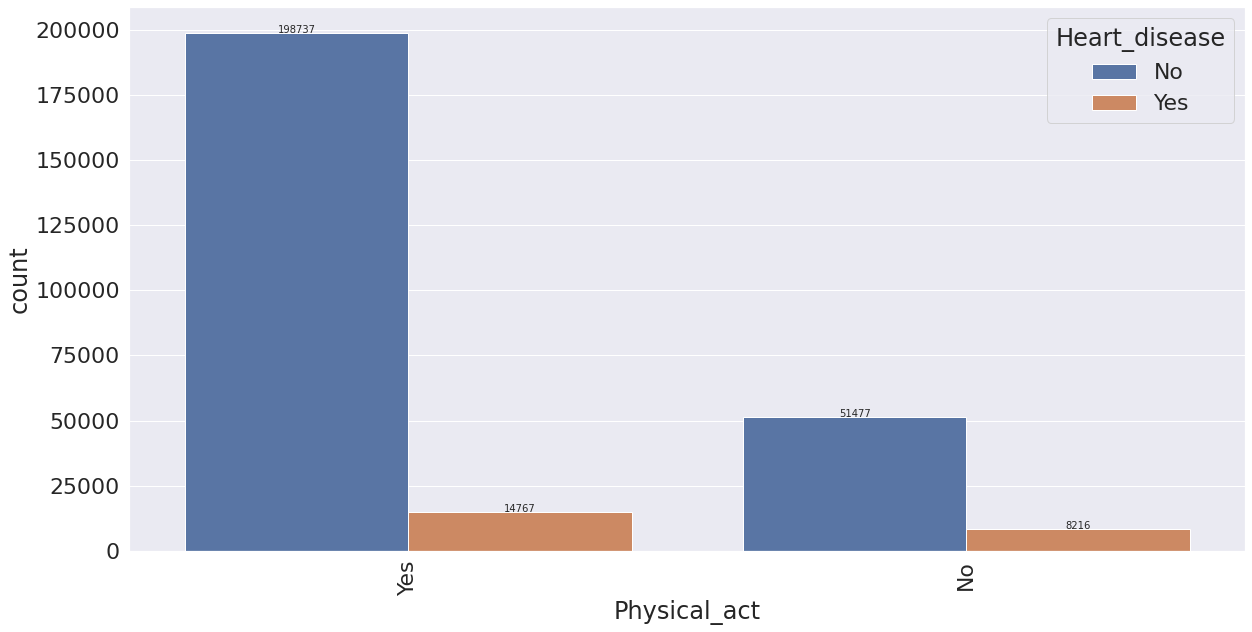

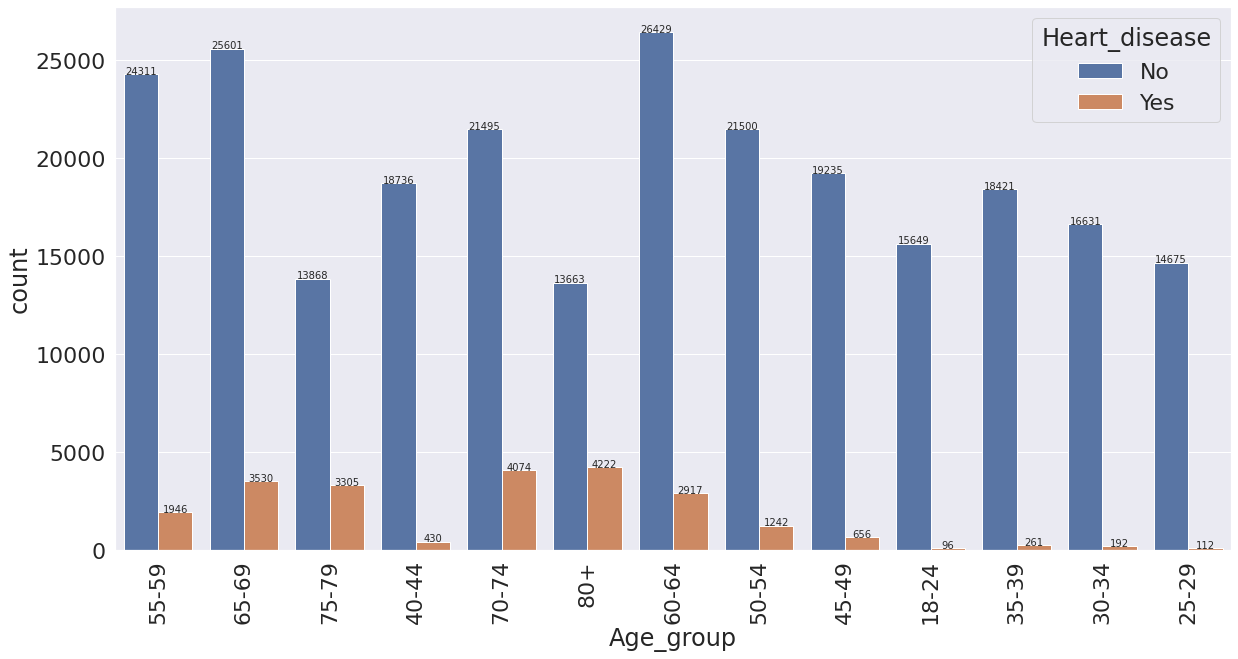

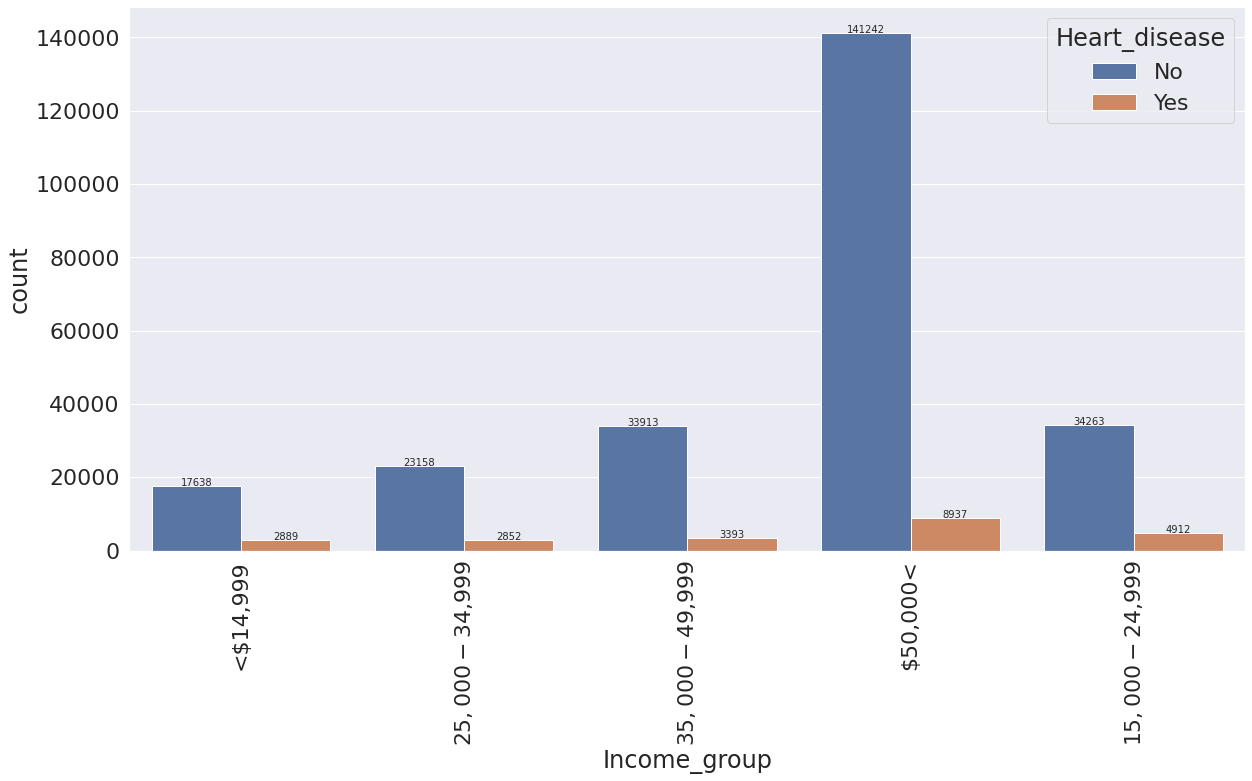

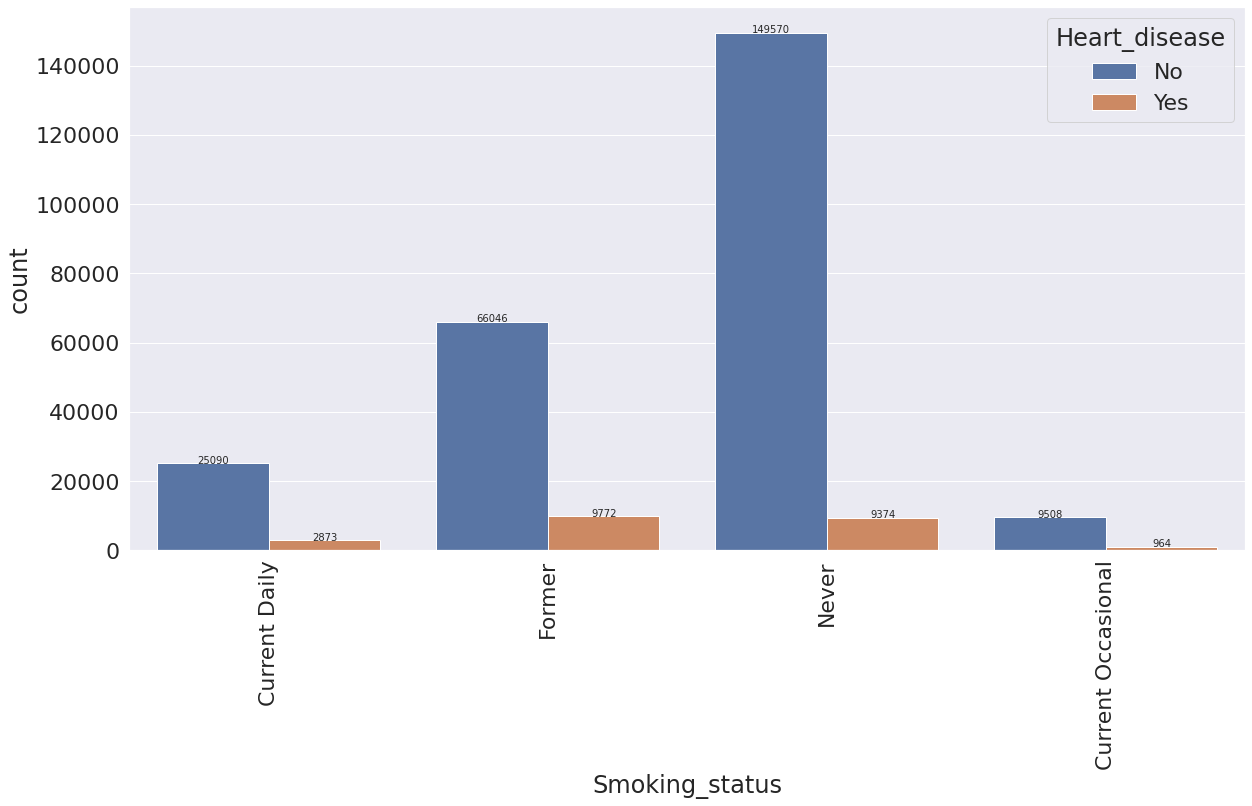

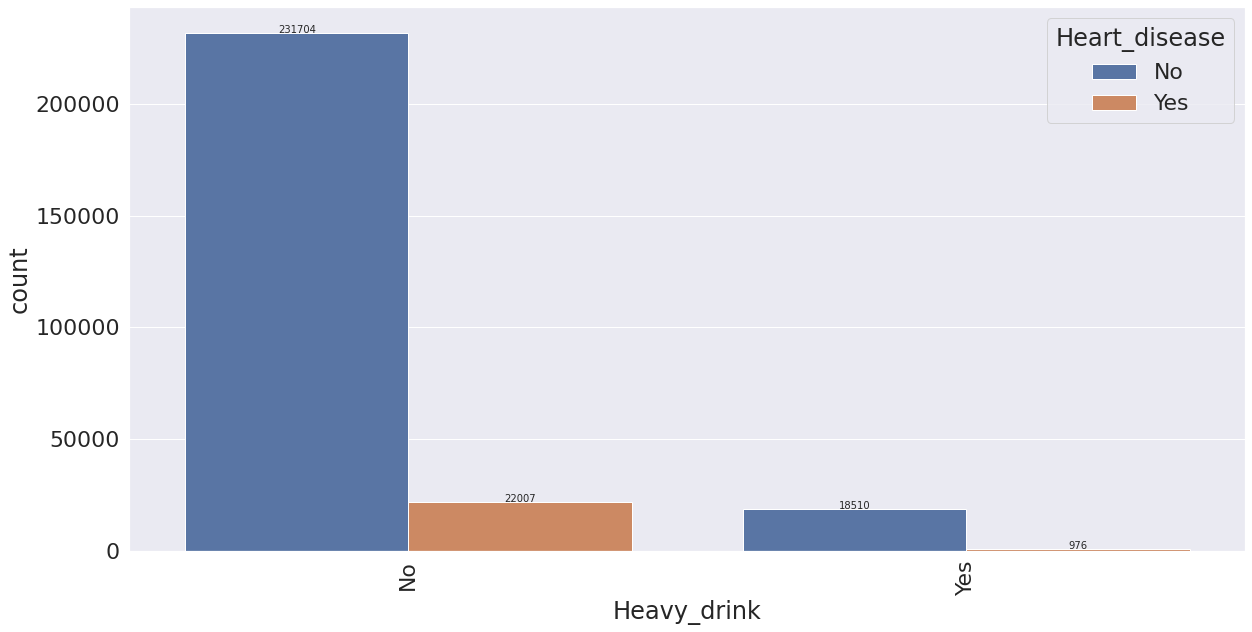

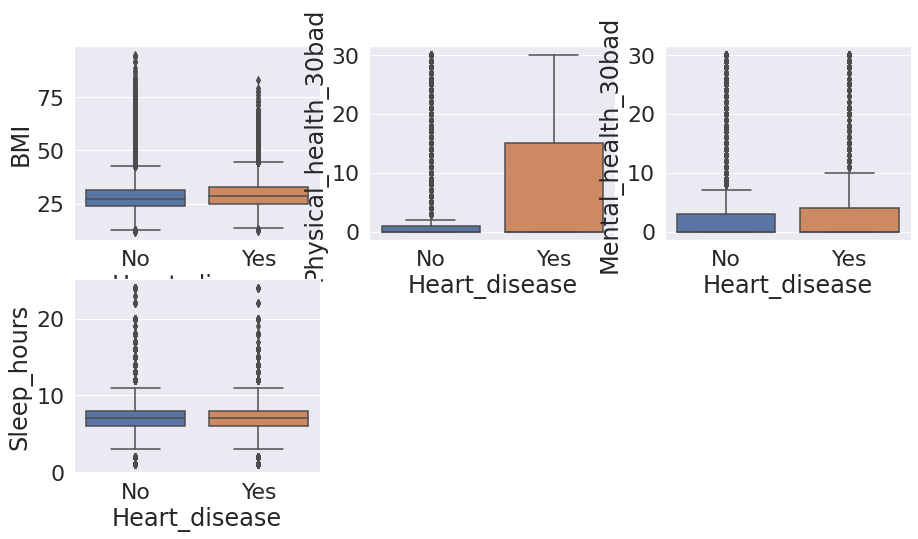

In [3]:
# Data plots used from iteration 3 as I don't think pySpark is suitable for plotting.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=2)

heart_data = pd.read_csv('Data/HeartData2020.csv')

sns.countplot(x='Heart_disease',data=heart_data)

for column_name in heart_data.columns:
    unique_values = len(heart_data[column_name].unique())

numeric_features=['BMI', 'Physical_health_30bad', 'Mental_health_30bad', 'Sleep_hours']
categorical_features=['Heart_disease','Sex', 'General_health', 'Medical_cost', 'Stroke', 'Asthma', 'Skin_cancer', 'Other_cancer', 'Education', 'Diff_con', 'Diff_walk', 'Smoked100', 'Good_health', 'Physical_act', 'Age_group', 'Income_group', 'Smoking_status', 'Heavy_drink' ]

for feature in categorical_features:
  fig, ax1 = plt.subplots(figsize=(20,10))
  graph = sns.countplot(ax=ax1,x = feature , data = heart_data,hue='Heart_disease')
  graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
  for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
    
    
i=1
plt.figure(figsize=(15,25))
for feature in numeric_features:
    plt.subplot(6,3,i)
    sns.boxplot(y=heart_data[feature], x = heart_data['Heart_disease'])
    i+=1

In [4]:
#Set correct values for numerical predictors

from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType,DoubleType
df2 = df.withColumn("Physical_health_30bad",col("Physical_health_30bad").cast(IntegerType())) \
    .withColumn("Mental_health_30bad",col("Mental_health_30bad").cast(IntegerType())) \
    .withColumn("Sleep_hours",col("Sleep_hours").cast(IntegerType())) \
    .withColumn("BMI",col("BMI").cast(DoubleType()))
df2.printSchema()

root
 |-- Sex: string (nullable = true)
 |-- General_health: string (nullable = true)
 |-- Physical_health_30bad: integer (nullable = true)
 |-- Mental_health_30bad: integer (nullable = true)
 |-- Medical_cost: string (nullable = true)
 |-- Sleep_hours: integer (nullable = true)
 |-- Stroke: string (nullable = true)
 |-- Asthma: string (nullable = true)
 |-- Skin_cancer: string (nullable = true)
 |-- Other_cancer: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Diff_con: string (nullable = true)
 |-- Diff_walk: string (nullable = true)
 |-- Smoked100: string (nullable = true)
 |-- Good_health: string (nullable = true)
 |-- Physical_act: string (nullable = true)
 |-- Heart_disease: string (nullable = true)
 |-- Age_group: string (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Income_group: string (nullable = true)
 |-- Smoking_status: string (nullable = true)
 |-- Heavy_drink: string (nullable = true)



In [5]:
max_bmi = df2.agg({"BMI": "max"}).collect()[0]
print(max_bmi)

Row(max(BMI)=94.66)


In [6]:
# Check for na's in the data

df2.na.drop().count() == df2.count()

True

In [7]:
# Relabel string varibales as numeric for modelling use

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.util import MLUtils
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer
from pyspark.mllib.util import MLUtils

cat_features = ["Heart_disease", "Sex", "General_health", "Medical_cost", "Stroke", "Asthma","Skin_cancer", "Other_cancer", "Education", "Diff_con", "Diff_walk", "Smoked100", "Good_health", "Physical_act","Age_group", "Income_group", "Smoking_status","Heavy_drink"]

for i in cat_features:
    indexer = StringIndexer(inputCol=i, outputCol= i+"Index")
    df2 = indexer.fit(df2).transform(df2)
    df2 = df2.drop(i)

In [8]:
df2.printSchema()

root
 |-- Physical_health_30bad: integer (nullable = true)
 |-- Mental_health_30bad: integer (nullable = true)
 |-- Sleep_hours: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Heart_diseaseIndex: double (nullable = false)
 |-- SexIndex: double (nullable = false)
 |-- General_healthIndex: double (nullable = false)
 |-- Medical_costIndex: double (nullable = false)
 |-- StrokeIndex: double (nullable = false)
 |-- AsthmaIndex: double (nullable = false)
 |-- Skin_cancerIndex: double (nullable = false)
 |-- Other_cancerIndex: double (nullable = false)
 |-- EducationIndex: double (nullable = false)
 |-- Diff_conIndex: double (nullable = false)
 |-- Diff_walkIndex: double (nullable = false)
 |-- Smoked100Index: double (nullable = false)
 |-- Good_healthIndex: double (nullable = false)
 |-- Physical_actIndex: double (nullable = false)
 |-- Age_groupIndex: double (nullable = false)
 |-- Income_groupIndex: double (nullable = false)
 |-- Smoking_statusIndex: double (nullable = f

In [9]:
# Set all predictors for feature selection

preds = ["Sex", "General_health", "Medical_cost", "Stroke", "Asthma","Skin_cancer", "Other_cancer", "Education", "Diff_con", "Diff_walk", "Smoked100", "Good_health", "Physical_act","Age_group", "Income_group", "Smoking_status","Heavy_drink"]
numeric = ["Physical_health_30bad", "Mental_health_30bad", "Sleep_hours", "BMI"]
features = []
for i in preds:
    features.append(i+"Index")
for j in numeric:
    features.append(j)

In [10]:
va = VectorAssembler(inputCols = features, outputCol='features')
va_df = va.transform(df2)
va_df = va_df.select(['features', 'Heart_diseaseIndex'])

In [11]:
va_df.show(5)

22/10/13 18:52:22 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+------------------+
|            features|Heart_diseaseIndex|
+--------------------+------------------+
|[0.0,0.0,1.0,0.0,...|               0.0|
|[1.0,3.0,0.0,0.0,...|               0.0|
|(21,[1,5,6,7,8,12...|               0.0|
|(21,[9,13,14,17,1...|               0.0|
|(21,[1,4,5,11,13,...|               0.0|
+--------------------+------------------+
only showing top 5 rows



In [12]:
(train, test) = va_df.randomSplit([0.8, 0.2])

In [13]:
# Use dt to find most important variables

dtc = DecisionTreeClassifier(featuresCol="features", labelCol="Heart_diseaseIndex")
dtc = dtc.fit(train)

In [14]:
dtc.featureImportances.toArray()

array([0.00596425, 0.00237428, 0.        , 0.13648486, 0.00285926,
       0.        , 0.        , 0.        , 0.        , 0.00317013,
       0.        , 0.47628901, 0.        , 0.37111656, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00174164,
       0.        ])

In [15]:
features

['SexIndex',
 'General_healthIndex',
 'Medical_costIndex',
 'StrokeIndex',
 'AsthmaIndex',
 'Skin_cancerIndex',
 'Other_cancerIndex',
 'EducationIndex',
 'Diff_conIndex',
 'Diff_walkIndex',
 'Smoked100Index',
 'Good_healthIndex',
 'Physical_actIndex',
 'Age_groupIndex',
 'Income_groupIndex',
 'Smoking_statusIndex',
 'Heavy_drinkIndex',
 'Physical_health_30bad',
 'Mental_health_30bad',
 'Sleep_hours',
 'BMI']

In [16]:
# Build df using important features

df3 = df2.select([c for c in df2.columns if c in ['Heart_diseaseIndex','SexIndex','General_healthIndex','StrokeIndex', 'Diff_walkIndex', 'Good_healthIndex', 'Age_groupIndex', 'Sleep_hours', 'BMI']])
features = ['SexIndex','General_healthIndex','StrokeIndex', 'Diff_walkIndex', 'Good_healthIndex', 'Age_groupIndex', 'Sleep_hours', 'BMI']
va = VectorAssembler(inputCols = features, outputCol='features')
va_df = va.transform(df3)
va_df = va_df.select(['features', 'Heart_diseaseIndex'])
(train, test) = va_df.randomSplit([0.8, 0.2])

In [17]:
# RandomForestClassifier

from pyspark.ml.classification import RandomForestClassifier


rfc = RandomForestClassifier(featuresCol="features", labelCol="Heart_diseaseIndex")
rfc = rfc.fit(train)

pred = rfc.transform(test)
evaluator=MulticlassClassificationEvaluator(labelCol="Heart_diseaseIndex",predictionCol="prediction")
acc = evaluator.evaluate(pred)
 
print("Prediction Accuracy: ", acc)

Prediction Accuracy:  0.8752886430904762


In [18]:
# GBTClassifier

from pyspark.ml.classification import GBTClassifier

gbc = GBTClassifier(featuresCol="features", labelCol="Heart_diseaseIndex", maxIter=10)
gbc = gbc.fit(train)

pred = gbc.transform(test)
evaluator=MulticlassClassificationEvaluator(labelCol="Heart_diseaseIndex",predictionCol="prediction")
acc = evaluator.evaluate(pred)
 
print("Prediction Accuracy: ", acc)

22/10/13 18:53:31 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/13 18:53:31 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Prediction Accuracy:  0.8809162154659664


In [19]:
# decision tree classifier

dtc = DecisionTreeClassifier(featuresCol="features", labelCol="Heart_diseaseIndex")
dtc = dtc.fit(train)

pred = dtc.transform(test)
evaluator=MulticlassClassificationEvaluator(labelCol="Heart_diseaseIndex",predictionCol="prediction")
acc = evaluator.evaluate(pred)
 
print("Prediction Accuracy: ", acc)

Prediction Accuracy:  0.8822639650023585


In [20]:
# Confusion matrix of results

from sklearn.metrics import confusion_matrix

y_true = pred.select("Heart_diseaseIndex")
y_true = y_true.toPandas()

y_pred = pred.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0.0, 1.0])
cnf_matrix

array([[49884,   225],
       [ 4439,   275]])

In [21]:
print(dtc.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_ddb46c12ac0e, depth=5, numNodes=25, numClasses=2, numFeatures=8
  If (feature 4 in {1.0})
   If (feature 5 in {2.0,4.0,5.0,6.0,7.0,10.0,11.0,12.0})
    If (feature 2 in {1.0})
     If (feature 1 in {3.0})
      Predict: 0.0
     Else (feature 1 not in {3.0})
      If (feature 5 in {7.0,11.0,12.0})
       Predict: 0.0
      Else (feature 5 not in {7.0,11.0,12.0})
       Predict: 1.0
    Else (feature 2 not in {1.0})
     Predict: 0.0
   Else (feature 5 not in {2.0,4.0,5.0,6.0,7.0,10.0,11.0,12.0})
    If (feature 2 in {1.0})
     If (feature 0 in {0.0})
      If (feature 1 in {4.0})
       Predict: 1.0
      Else (feature 1 not in {4.0})
       Predict: 0.0
     Else (feature 0 not in {0.0})
      Predict: 1.0
    Else (feature 2 not in {1.0})
     Predict: 0.0
  Else (feature 4 not in {1.0})
   If (feature 5 in {0.0,2.0,4.0,5.0,6.0,7.0,10.0,11.0,12.0})
    If (feature 2 in {1.0})
     If (feature 3 in {1.0})
      If (feature 6

In [22]:
dtc.featureImportances.toArray()

array([0.00501203, 0.00785425, 0.14131655, 0.00464409, 0.46494929,
       0.37325421, 0.00296958, 0.        ])

In [23]:
features

['SexIndex',
 'General_healthIndex',
 'StrokeIndex',
 'Diff_walkIndex',
 'Good_healthIndex',
 'Age_groupIndex',
 'Sleep_hours',
 'BMI']